# Topic Modelling on User Description

The present notebook is part of a series of notebooks related to the MSc. thesis: **Sentiment analysis on generative language models    based on Social Media commentary of industry participants**

The MSc. thesis research was conducted based on tweets about ChatGPT. These were collected, processed and analyzed with the scope of answering the following research question:

**How are generative language models perceived by participants of different industries based on social media commentary?**

A focal point in answering the research question consists of identifying the industries the users discussing ChatGPT belong to. In this sense, this notebook was used to further clean the user description data and to extract the topics of these descriptions with the help of unsupervised machine learning techniques sucha as: Latent Dirichlet Allocation. 

In [1]:
#Import cell of necessary packages
import pandas as pd
import numpy as np

#Set pandas max rows option as max 500 for ease of cleaning
pd.set_option('display.max_rows', 500)
pd.options.mode.chained_assignment = None

#Package to surpass long warnings
import warnings
warnings.simplefilter(action='ignore')
warnings.filterwarnings("ignore", category = DeprecationWarning) 

#Method from functools package that compares data based on key in dict
from functools import cmp_to_key #comparing function 

#Import module to ease data transformation for LDA models
from gensim.corpora.dictionary import Dictionary # Import the dictionary builder
#Import LDA module
from gensim.models import LdaMulticore # we'll use the faster multicore version of LDA
#Importing module to calculate coherence of LDA models
from gensim.models import CoherenceModel
#Import modules to be able to save LDA models
from gensim.test.utils import datapath
from gensim import  models
#Package used in fitting corpus for LDA topic modelling
import nltk.corpus
#Packages and models used to visualise LDA model results
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

#Packages used for data visualisation 
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from matplotlib import pyplot as plt

c:\Users\oanaa\anaconda3\envs\CodeBase\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\oanaa\anaconda3\envs\CodeBase\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\oanaa\anaconda3\envs\CodeBase\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\oanaa\anaconda3\envs\CodeBase\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


### Data Preprocessing

In this section of the notebook the *user description dataset* is further pre-processed before the LDA model is trained on the user descriptions. 

This section has been run multiple times based on the observations drawn from the results of the LDA model. 
To increase the LDA model's coherence and the interpretabality of the resulting topics, words that were considered redundant were removed from the corpus of the model. 

In [2]:
#Load user description data
user_prepro_df = pd.read_csv('data_files/UsrData_PreLDA.csv')

#transform usr_description_tokens column into lists
for col in ['usr_description_tokens']:
    user_prepro_df[f'{col}'] = user_prepro_df[f'{col}'].apply(lambda x: x.strip("']['").split("', '"))

#inspect how dataframe looks like 
user_prepro_df.tail(3)

,usr_userid,usr_description_origin,usr_description_prepro,usr_description_hashtags,usr_description_mentions,usr_description_URLs,usr_description_emoji,usr_description_clean,usr_description_tokens
698719,832624291724144640,coder interested in #ai #ML #sentience #health...,NaN,"['ai', 'ML', 'sentience', 'health']",[],[],NaN,coder interested in of extensant citizen initi...,"[extensant, initiative, interested, citizen, c..."
698720,327337127,Founder @PplPolicyProj: patreon.com/peoplespol...,NaN,[],"['PplPolicyProj', 'ebruenig']","['patreon.com/peoplespolicyp….', 'patreon.com/...",NaN,founder co-host of the bruenigs with,"[host, -, co, founder, bruenig]"
698721,1207075000164864000,enjoyer of long walks in the dungeon.,NaN,[],[],[],NaN,enjoyer of long walks in the dungeon,"[enjoyer, dungeon, walk, long]"


In [3]:
user_prepro_df.shape

(698722, 9)

In [3]:
#Inspect how users with no description look like 
user_prepro_df[user_prepro_df["usr_description_origin"].isna()].tail()

,usr_userid,usr_description_origin,usr_description_prepro,usr_description_hashtags,usr_description_mentions,usr_description_URLs,usr_description_emoji,usr_description_clean,usr_description_tokens
698705,2469116083,NaN,NaN,[],[],[],NaN,NaN,[nan]
698706,1570786718017617921,NaN,NaN,[],[],[],NaN,NaN,[nan]
698707,1644445633128833025,NaN,NaN,[],[],[],NaN,NaN,[nan]
698708,1625106180090757120,NaN,NaN,[],[],[],NaN,NaN,[nan]
698709,1644071118460837890,NaN,NaN,[],[],[],NaN,NaN,[nan]


In [57]:
#extra_stop_words list stores other words that were observed in the corpus and are considered noise 
extra_stop_words = ['r','rt','an','dm','le','yo','por','I','el','lo','con','x','u',
                    '',"","-","also" "k","c","oth","rth","0",'da',
                    "e", "la", "prev","e", "k","et","un", str(np.nan), 'nan', 'NaN'                    
                    'dad','hehim','mom',
                    'father','husband','sheh','que','god','man','woman','married',
                    'christian','guy','alway','always','person','vida','friend','stuff',
                    'never','bear','son','eth','fuck','they','them','she','her',
                    'je','wife','mother','jesus','b','st','I','l','sheher','non',
                    'hehim','theythem','theythem','shehim','shethem','son','daughter',
                    'brother','sister','them',"thing", "random","much","many","de","sometimes",] 

In [58]:
#removal of words considered as noise
user_prepro_df[f'usr_description_tokens'] = user_prepro_df[f'usr_description_tokens'].apply(lambda x: x if type(x) == type(None) else list(set(x).difference(extra_stop_words)))

In [59]:
#Create a usr_industry_categ column meant to store the results of the topic modelling conducted on user descriptions
user_prepro_df['urs_industry_categ'] = ""
#Users that do not have an industry description or any user description tokens will be assigned the "NotSpecified" category 
user_prepro_df['urs_industry_categ'] = user_prepro_df['usr_description_tokens'].apply(lambda x: "NotSpecified" if len(x)==0 else "")


In [60]:
#Inspect how data looks like once the new column is added
user_prepro_df[user_prepro_df["usr_description_origin"].isna()].head()

,usr_userid,usr_description_origin,usr_description_prepro,usr_description_hashtags,usr_description_mentions,usr_description_URLs,usr_description_emoji,usr_description_clean,usr_description_tokens,urs_industry_categ
315392,1445936017987440644,NaN,"Plagiarist, utilizer, curious about nature, cy...",[],[],[],NaN,plagiarist utilizer curious about nature cynic...,"[curious, plagiarist, multispecular, fascinate...",
455667,225923287,NaN,i don’t support Trump2024,[],[],[],NaN,i dont support trump,"[trump, support]",
464363,1521638921209192449,NaN,🇺🇸,[],[],[],🇺🇸,NaN,[],NotSpecified
615751,2496666240,NaN,NaN,[],[],[],NaN,NaN,[],NotSpecified
615752,825495264270114816,NaN,NaN,[],[],[],NaN,NaN,[],NotSpecified


In [61]:
#Inspect how the rows being categorised as 'NotSpecified' look like
user_prepro_df[user_prepro_df["urs_industry_categ"] == "NotSpecified"].head()

,usr_userid,usr_description_origin,usr_description_prepro,usr_description_hashtags,usr_description_mentions,usr_description_URLs,usr_description_emoji,usr_description_clean,usr_description_tokens,urs_industry_categ
12,38374100,#Cloudtechnology / #web3 / #softwareengineerin...,#Cloudtechnology / #web3 / #softwareengineerin...,"['Cloudtechnology', 'web3', 'softwareengineeri...",[],[],NaN,,[],NotSpecified
41,1605,@OpenAI,@OpenAI,[],['OpenAI'],[],NaN,NaN,[],NotSpecified
92,4691850570,🐕🎡🎠🍵🌻🌈🌌🦄,🐕🎡🎠🍵🌻🌈🌌🦄,[],[],[],🐕🎡🎠🍵🌻🌈🌌🦄,NaN,[],NotSpecified
127,1442574755006087171,🤠\n\ngiphy.com/channel/shellw…,🤠\n\ngiphy.com/channel/shellw…,[],[],['giphy.com/channel/shellw…'],🤠,NaN,[],NotSpecified
169,1272995053691076608,I’m a person,I’m a person,[],[],[],NaN,im a person,[],NotSpecified


In [21]:
#Check no. of users with NotSpecified industry 
user_prepro_df[user_prepro_df["urs_industry_categ"]=="NotSpecified"].shape

(105065, 10)

In [62]:
#Select the data that is not "NotSpecified" as introduction 
topic_df = user_prepro_df[user_prepro_df["urs_industry_categ"] != "NotSpecified"]
topic_df.shape

(593657, 10)

## Users' Description LDA 

To infer the industry to which Twitter users belong, the unsupervised machine learning model (Latent Dirichlet Allocation) has been used. 
LDA is a generative probabilistic model which employs unsupervised learning techniques to find clusters of similar topics among the words provided in the documents used as input data (Blei et al., 2003).

To fit an LDA model on the descriptions of users, this paper made used of tha **LDAMulticore** model of the **gensim** python package. 

In [10]:
#Create a dictionary of the words present in the usr_description column 
dictionary = Dictionary(topic_df['usr_description_tokens'])
#filter out low-frequency / high-frequency words
dictionary.filter_extremes(no_below=10, no_above=0.5)
#create corpus from the usr_descriptions_tokens column
corpus = [dictionary.doc2bow(doc) for doc in topic_df['usr_description_tokens']]

A first step in fitting and LDA model to the users' description data was to instantiate a base model that will be further tuned for better results.
The model will be assesed based on its coherence score that serves as an indicator to how interpretable the topics are to human readers. 

In [13]:
#Fit a based LDA model with 12 topics
lda_model12 = LdaMulticore(corpus, id2word=dictionary, num_topics=12, workers = 4, passes=10, iterations= 25)

In [14]:
#Check coherence score of base model 
coherence_model_lda12 = CoherenceModel(model=lda_model12, texts=topic_df['usr_description_tokens'], dictionary=dictionary, coherence='c_v')
coherence_lda12 = coherence_model_lda12.get_coherence()
print('Coherence Score 12 Topics: ', coherence_lda12)

Coherence Score 12 Topics:  0.5118806133667163


In [15]:
##SaveUSR LDA Model
lda_model12.save('pre_TunedUserLDA/userLDA_PRE_Tuned')

In [101]:
#Visualize base LDA model 
lda_display12 = pyLDAvis.gensim_models.prepare(lda_model12, corpus, dictionary)
pyLDAvis.display(lda_display12)

In [116]:
#Print topic clusters resulted from base LDA model 
lda_model12.print_topics()

[(0,
  '0.041*"good" + 0.040*"founder" + 0.031*"make" + 0.028*"co" + 0.026*"world" + 0.025*"life" + 0.018*"work" + 0.016*"real" + 0.016*"people" + 0.015*"build"'),
 (1,
  '0.035*"crypto" + 0.028*"investor" + 0.022*"financial" + 0.018*"market" + 0.018*"advice" + 0.017*"trader" + 0.016*"thought" + 0.016*"share" + 0.014*"money" + 0.014*"self"'),
 (2,
  '0.015*"pro" + 0.015*"anti" + 0.015*"scientist" + 0.014*"data" + 0.014*"free" + 0.013*"datum" + 0.011*"analyst" + 0.009*"english" + 0.009*"streamer" + 0.009*"liberal"'),
 (3,
  '0.025*"science" + 0.024*"view" + 0.022*"student" + 0.019*"phd" + 0.017*"research" + 0.014*"opinion" + 0.013*"professor" + 0.013*"university" + 0.012*"researcher" + 0.011*"director"'),
 (4,
  '0.043*"nft" + 0.017*"que" + 0.014*"crypto" + 0.012*"collector" + 0.012*"web" + 0.011*"artist" + 0.011*"en" + 0.011*"curious" + 0.010*"blockchain" + 0.009*"discord"'),
 (5,
  '0.019*"go" + 0.016*"know" + 0.012*"see" + 0.011*"man" + 0.010*"right" + 0.010*"think" + 0.010*"come" + 

In [125]:
#Create dictionary where keys are the index of topic clusters resulted from base LDA and values are potetntial naming convention of these clusers
lda_dict = {0:'Entrepreneurship',
            1:'Crypto & Finance',
            2:'NotClear',
            3:'Education & Academia',
            4:'Crypto & Web 4.0',
            5:'NotClear',
            6:'NotClear',
            7:'Arts & Entertainment',
            8:'News & Commentary',
            9:'Writers',
            10:'Business & Marketing',
            11:'Software Development',
            '-':'-'}


In [147]:
#Defining a classifier function to use for labelling each user with an industry 
def classifier(texts,model,topics_dict):

  #get probabilities list for each observation in list of tuples format [(cluster_no, probability)...]
  texts_clean = texts.apply(lambda t: model[dictionary.doc2bow(t)])

  # First: sort probabilities list by probability in desc order (list of tuples e.g. (cluster_no, probabilty))
  # Second: get cluster number of first element (highest probability) 
  # Third: convert cluster number (lda_dict key) to predefined cluser name (lda_dict value)

  texts_clean = texts_clean.apply( lambda t: topics_dict[sorted(t, reverse=True, key=cmp_to_key(lambda item1, item2: item1[1] - item2[1]))[0][0]] )

  return texts_clean

In [127]:
#Classify the users descriptions into labels resulted from lda base model
topic_df['urs_industry_categ']= classifier(topic_df['usr_description_tokens'],lda_model12,lda_dict)

### Tuning Users' Description LDA 

The base LDA model had a **coherence score of 0.5167870900**. 
While this is not an inherently bad score, this section of the notebook tries to provide an LDA model which records a higher coherence score. 
To increase the coherence of a LDA model multiple techniques can be employed such as tweaking the parameters of the model or assuring further data cleaning for words considered as noise. 

In this project the following techniques were used:
* further cleaning for noise words (Section: Data Preprocessing)
* tweaking the *k - num_topics (number of topics)* parameter of the LDA model 

As a result it can be seen that a LDA with coherence above **0.56** was returned. This model was further used to label the topics of the user descriptions so that each user could be categorized to one industry. 

In [21]:
#The code in this cell is inspired by Sahil Mahajan's (2021) article:  https://www.linkedin.com/pulse/nlp-a-complete-guide-topic-modeling-latent-dirichlet-sahil-m/

#Define function to compute coherence for LDA models with different choices of topic numbers 
def compute_coherence_values(corpus_, dictionary_,text,limit = 1,start=6,step=2):

    coherence_vals=[]
    model_list=[]

    for num_topics in range(start,limit,step):
        #Train LDA model with num_topics number of topics
        model= LdaMulticore(corpus_, id2word=dictionary_, num_topics=num_topics, workers = 4, passes=10)
        #Calculate coherence of the model trained
        coherence_model = CoherenceModel(model=model, texts=text, dictionary=dictionary_, coherence='c_v')
        #Append coherence values and model list to the coherence_vals and model_lists respectively
        coherence_vals.append(coherence_model.get_coherence())
        model_list.append(model)

    return model_list, coherence_vals


In [22]:
#Compute coherence scores for LDA models with number of topics between 6 and 20 with steps of 2
user_model_list, coherence_values = compute_coherence_values(corpus, dictionary,topic_df['usr_description_tokens'],limit=20,start=6,step=2)

<function matplotlib.pyplot.show(close=None, block=None)>

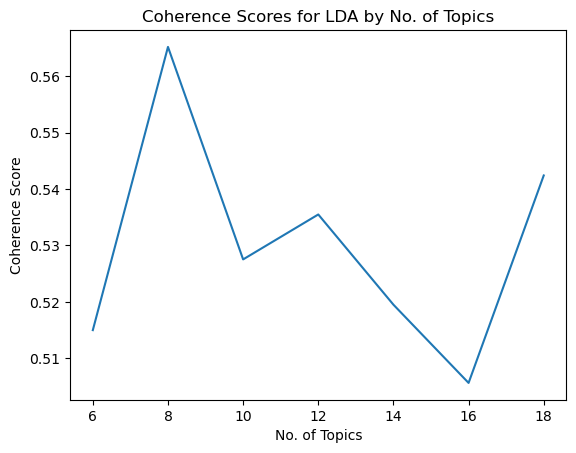

In [150]:
#The code in this cell is inspired by Sahil Mahajan's (2021) article:  https://www.linkedin.com/pulse/nlp-a-complete-guide-topic-modeling-latent-dirichlet-sahil-m/
#Plot coherence values resulted from computing multiple coherences

graph_coherence= range(6, 20, 2)
plt.plot(graph_coherence, coherence_values)
plt.title("Coherence Scores for LDA by No. of Topics")
plt.xlabel("No. of Topics")
plt.ylabel("Coherence Score")
plt.savefig('usr_topicmodel_coherenceV1.png')
plt.show

In [27]:
#Create dictionary of resulting models and coherence scores, that will be used to select best performing LDA model
res_models = {graph_coherence[i]: (coherence_values[i],user_model_list[i]) for i in range(len(graph_coherence))}
res_models

{6: (0.5149889959374491,
  <gensim.models.ldamulticore.LdaMulticore at 0x26f80cd2770>),
 8: (0.5651888382512682,
  <gensim.models.ldamulticore.LdaMulticore at 0x2703dbc8af0>),
 10: (0.5275255483817933,
  <gensim.models.ldamulticore.LdaMulticore at 0x2703dbca860>),
 12: (0.5354888633754634,
  <gensim.models.ldamulticore.LdaMulticore at 0x27051a54eb0>),
 14: (0.5194994557703561,
  <gensim.models.ldamulticore.LdaMulticore at 0x26fb0956e60>),
 16: (0.505631277196121,
  <gensim.models.ldamulticore.LdaMulticore at 0x26f80cd1b40>),
 18: (0.5424035303121868,
  <gensim.models.ldamulticore.LdaMulticore at 0x27037683940>)}

In [28]:
#store best performing LDA model from the previous step as usr_ldaModel
usr_ldaModel = res_models[8][1]
usr_ldaModel

In [29]:
#Visualized LDA of 8 topics with best coherence
usr_lda_display8 = pyLDAvis.gensim_models.prepare(usr_ldaModel, corpus, dictionary)
pyLDAvis.display(usr_lda_display8)

In [80]:
#Save LDA Model on user description with 8 resulting topics
usr_ldaModel.save('post_TunedUserLDA/userLDA_Tuned')

In [11]:
#Test reading the model from stored location
usr_ldaModel = models.ldamodel.LdaModel.load('post_TunedUserLDA/userLDA_Tuned')
usr_ldaModel.print_topics()

[(0,
  '0.038*"engineer" + 0.032*"software" + 0.031*"developer" + 0.024*"enthusiast" + 0.018*"web" + 0.018*"designer" + 0.016*"tech" + 0.015*"ai" + 0.012*"dev" + 0.012*"full"'),
 (1,
  '0.026*"business" + 0.022*"digital" + 0.018*"build" + 0.017*"marketing" + 0.014*"news" + 0.014*"help" + 0.012*"content" + 0.010*"medium" + 0.009*"ai" + 0.009*"product"'),
 (2,
  '0.028*"life" + 0.026*"make" + 0.023*"world" + 0.019*"good" + 0.014*"people" + 0.013*"learn" + 0.012*"work" + 0.012*"live" + 0.011*"time" + 0.010*"love"'),
 (3,
  '0.042*"founder" + 0.026*"co" + 0.020*"director" + 0.018*"author" + 0.017*"view" + 0.016*"writer" + 0.016*"ceo" + 0.014*"editor" + 0.014*"opinion" + 0.013*"host"'),
 (4,
  '0.031*"crypto" + 0.023*"nft" + 0.020*"investor" + 0.015*"financial" + 0.012*"advice" + 0.012*"trader" + 0.012*"enthusiast" + 0.011*"entrepreneur" + 0.010*"market" + 0.010*"speaker"'),
 (5,
  '0.016*"phd" + 0.016*"student" + 0.015*"science" + 0.014*"research" + 0.012*"social" + 0.011*"university" + 0.

In [51]:
#Create dictionary that stores labels for each of the resulting topics from usr_ldaModel
usr_lda_dict = {0:'Software Engineering',
            1:'Marketing & Business Development',
            2:'NotIndustry(1)',
            3:'Entrepreneurship & Business Leadership',
            4:'Finance & Crypto',
            5:'Education & Academia',
            6:'Arts & Entertainment',
            7:'NotIndustry(2)',
            '-':'-'}


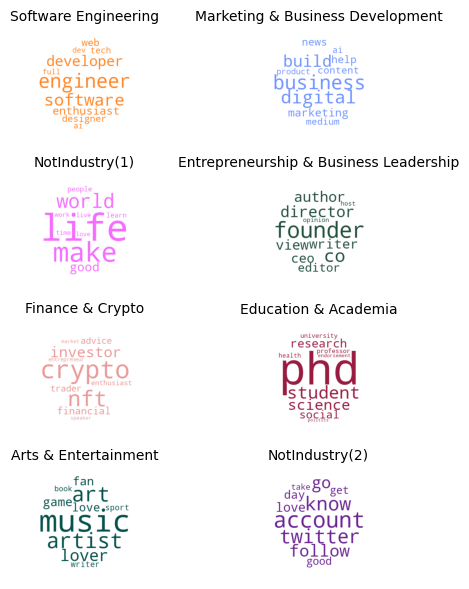

In [52]:
#Code in this cell was inspired by Selva Prabhakaran (source url: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/ )

#Visualize all 8 topics identified

cols = [color for color in ['#ff8625','#6f93ff','#f56cff','#224f3c','#ea9999','#981c41','#05504c','#6a2292']] #mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

cloud = WordCloud(stopwords=extra_stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='hsv_r',
                  mask=mask,
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = usr_ldaModel.show_topics(formatted=False)

fig, axes = plt.subplots(4, 2, figsize=(6,6), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title(usr_lda_dict[i], fontdict=dict(size=10))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig("UserDescritption_TopicsVisual.jpg")
plt.show()

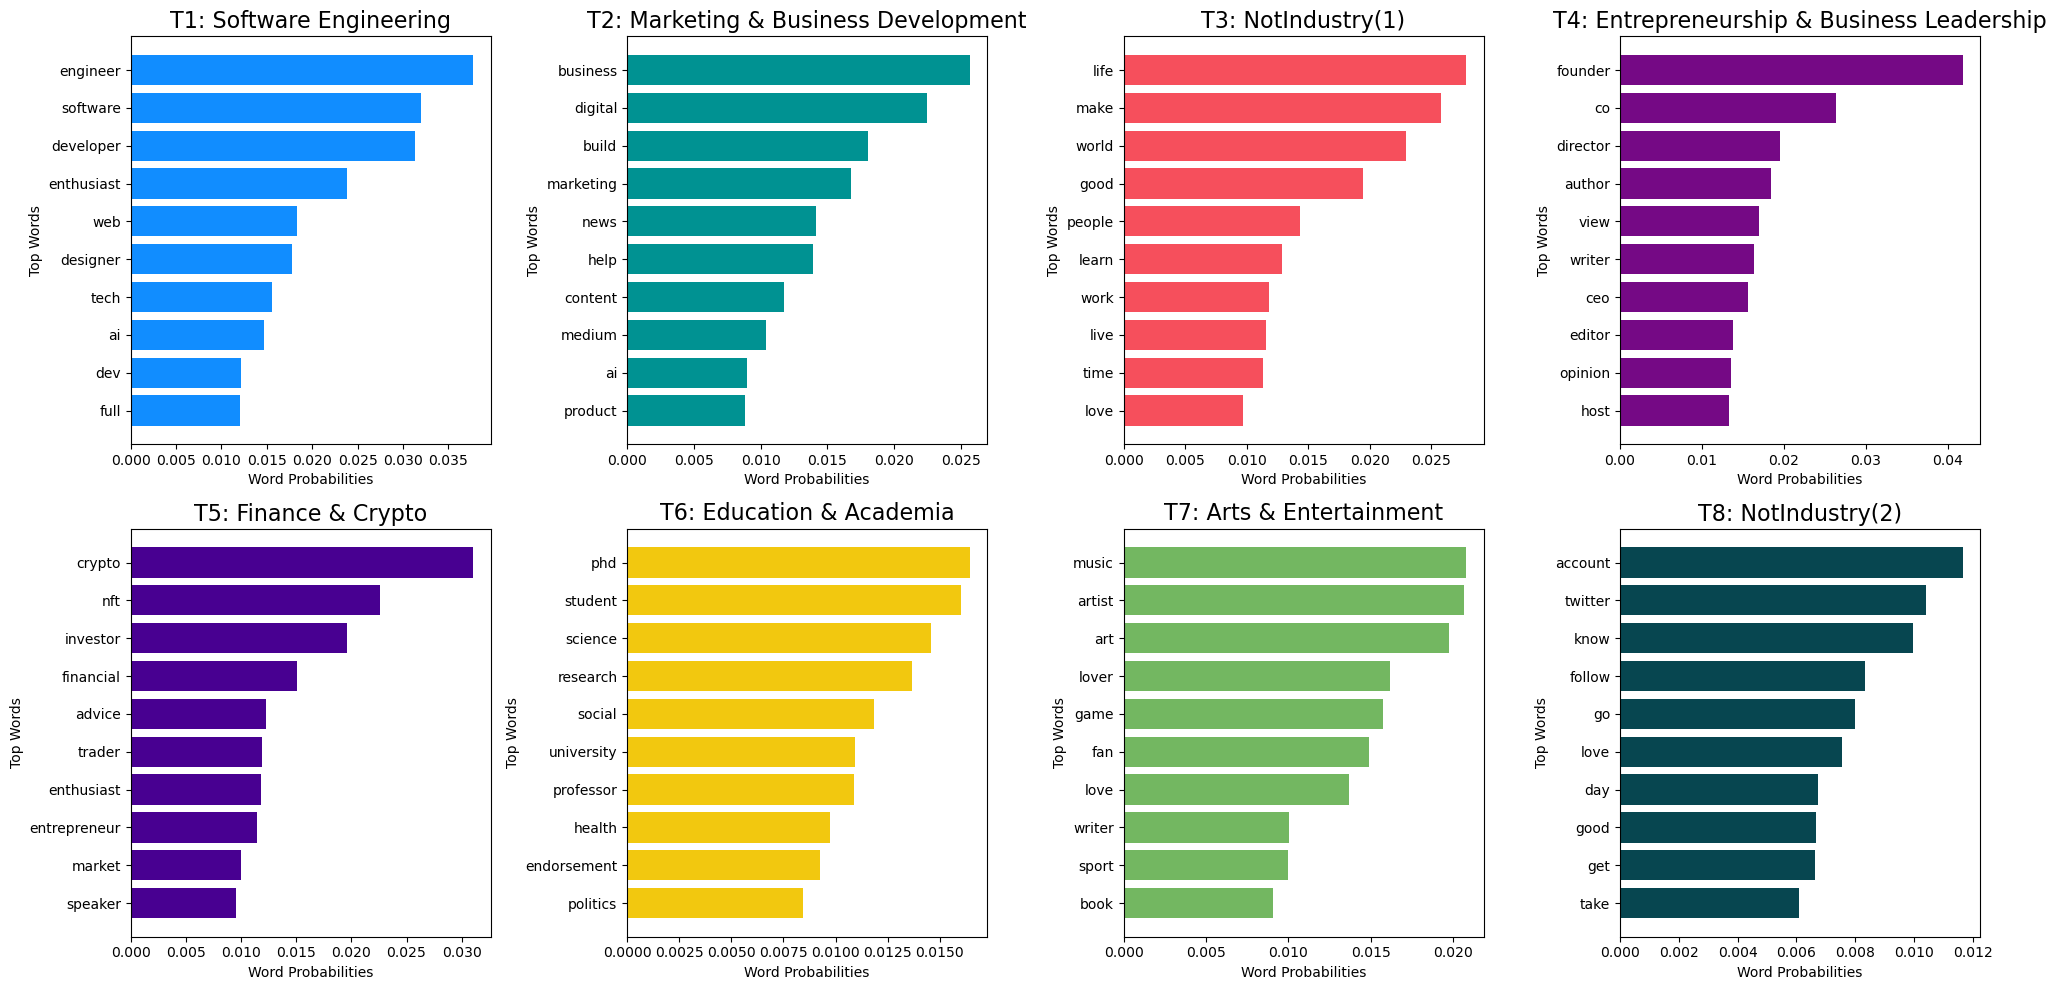

In [53]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
axes = axes.ravel()

colors = ['#118DFF', '#009292', '#F64F5C', '#750985','#480091','#F2C80F','#73B761','#074650']

# plot the top words for each topic as a horizontal bar plot
for topic_num in range(usr_ldaModel.num_topics):
    words = [word for word, prob in usr_ldaModel.show_topic(topic_num)]
    probs = [prob for word, prob in usr_ldaModel.show_topic(topic_num)]
    probs_sorted, words_sorted = zip(*sorted(zip(probs, words), reverse=False))
    axes[topic_num].barh(words_sorted, probs_sorted,color=colors[topic_num])
    axes[topic_num].set_yticklabels(words_sorted, ha='right')
    axes[topic_num].set_xlabel('Word Probabilities')
    axes[topic_num].set_ylabel('Top Words')
    axes[topic_num].set_title(f'T{topic_num+1}: {usr_lda_dict[topic_num]}', fontsize=16)
    fig.subplots_adjust(wspace=1.1, hspace=1)
    plt.savefig(f'user_topic_probabilities.jpg')

plt.tight_layout()
plt.show()
#plt.savefig(f'user_topic_probabilities.jpg', bbox_inches='tight')

Based on the results from the LDA model resulting in the above 8 topics, each tweeter user is clasisifed into an industry. 

In [46]:
#Classify the user descriptions into the industries identified based on usr_ldaModel
topic_df['urs_industry_categ']= classifier(topic_df['usr_description_tokens'],usr_ldaModel,usr_lda_dict)

In [47]:
#Check labelling 
topic_df['urs_industry_categ'].unique()

array(['Arts & Entertainment', 'NotIndustry(1)',
       'Entreprenourship & Business Commentary', 'Software Engingeering',
       'NotIndustry(2)', 'Marketing and Business Development',
       'Education & Academia', 'Finance & Crypto'], dtype=object)

In [154]:
#TODO:only remove last comment below if labels need to be modified
#Merge the topic_df with the rows that are classified as NotSpecified and save the new data
#pd.concat([topic_df,user_prepro_df[user_prepro_df["urs_industry_categ"]=="NotSpecified"]]).to_csv("usr_TopicLabelledFINAL.csv",index= False)

In [2]:
user_data = pd.read_csv("data_files//usr_TopicLabelledFINAL.csv")
user_data['usr_userid']=user_data['usr_userid'].astype(str)
user_data.shape

(698722, 10)

In [11]:
#Check count of all categories
user_data.groupby(["urs_industry_categ"])['usr_userid'].count()

urs_industry_categ
Arts & Entertainment                       68138
Education & Academia                       65601
Entreprenourship & Business Commentary     52426
Finance & Crypto                           47440
Marketing and Business Development         93379
NotIndustry(1)                             76223
NotIndustry(2)                            101387
NotSpecified                              105090
Software Engingeering                      89038
Name: usr_userid, dtype: int64